# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


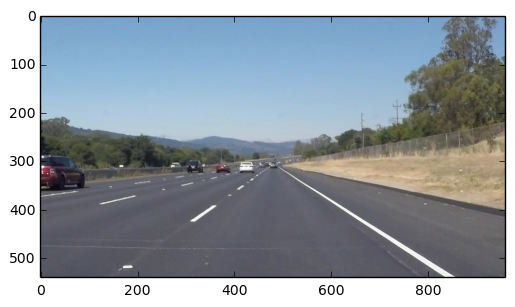

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [43]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines_new(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = draw_lines_new(img, lines, color=[255, 0, 0], thickness=3)
    return line_img

def draw_lines_new(img, lines, color=[255, 0, 0], thickness=2):
    
    left_points = np.array([])
    right_points = np.array([])
    
    for line in lines:
        for x1, y1, x2, y2 in line:
                                   
            points = np.array([x1, y1, x2, y2]).reshape((1, 4))
            
            if (x2 - x1 + 0.0)/(y2 - y1 + 0.0) > 0:
                if right_points.size == 0:
                    right_points = points
                else:
                    right_points = np.vstack((right_points, points))
            else:
                if left_points.size == 0:
                    left_points = points
                else:
                    left_points = np.vstack((left_points, points))
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    for w in range(470):
        for h in range(320, 539):
            
            if img[h, w] == 255:
                distL = distance_to_lines(left_points, (w, h))
                
                if distL < 10:
                    left_x.append(w)
                    left_y.append(h)
    
    for w in range(480, 899):
        for h in range(320, 539):
            
            if img[h, w] == 255:
                distL = distance_to_lines(right_points, (w, h))
                
                if distL < 10:
                    right_x.append(w)
                    right_y.append(h)

    corr_left = np.polyfit(np.array(left_y), np.array(left_x), 1)
    p_left = np.poly1d(corr_left)
    corr_right = np.polyfit(np.array(right_y), np.array(right_x), 1)
    p_right = np.poly1d(corr_right)

                
    apex = [539, 320]    
    
    img0 = np.zeros_like(img)
    img0 = np.tile(img0[:, :, np.newaxis], [1, 1, 3])
    
    #print([(int(p_left(apex[0])), apex[0]), (int(p_left(apex[1])), apex[1])])
    #print([(int(p_right(apex[0])), apex[0]), (int(p_right(apex[1])), apex[1])])
    
    cv2.line(img0, (int(p_left(apex[0])), apex[0]), (int(p_left(apex[1])), apex[1]), color=color, thickness=thickness)
    cv2.line(img0, (int(p_right(apex[0])), apex[0]), (int(p_right(apex[1])), apex[1]), color=color, thickness=thickness)
    
    return img0    

def hough_lines_new_720(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = draw_lines_new_720(img, lines, color=[255, 0, 0], thickness=3)
    return line_img

def draw_lines_new_720(img, lines, color=[255, 0, 0], thickness=2):
    
    left_points = np.array([])
    right_points = np.array([])
    
    for line in lines:
        for x1, y1, x2, y2 in line:
                                   
            points = np.array([x1, y1, x2, y2]).reshape((1, 4))
            
            slope = np.abs( (x2 - x1 + 0.0)/(y2 - y1 + 0.0) )
            if not (slope > 1 and slope < 3):
                continue
                
            if (x2 - x1 + 0.0)/(y2 - y1 + 0.0) > 0:
                if right_points.size == 0:
                    right_points = points
                else:
                    right_points = np.vstack((right_points, points))
            else:
                if left_points.size == 0:
                    left_points = points
                else:
                    left_points = np.vstack((left_points, points))
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    for w in range(680):
        for h in range(405, 660):
            
            if img[h, w] == 255:
                distL = distance_to_lines(left_points, (w, h))
                
                if distL < 5:
                    left_x.append(w)
                    left_y.append(h)
    
    for w in range(710, 1180):
        for h in range(405, 660):
            
            if img[h, w] == 255:
                distL = distance_to_lines(right_points, (w, h))
                
                if distL < 5:
                    right_x.append(w)
                    right_y.append(h)

    corr_left = np.polyfit(np.array(left_y), np.array(left_x), 1)
    p_left = np.poly1d(corr_left)
    corr_right = np.polyfit(np.array(right_y), np.array(right_x), 1)
    p_right = np.poly1d(corr_right)

                
    apex = [660, 400]    
    
    img0 = np.zeros_like(img)
    img0 = np.tile(img0[:, :, np.newaxis], [1, 1, 3])
    
    #print([(int(p_left(apex[0])), apex[0]), (int(p_left(apex[1])), apex[1])])
    #print([(int(p_right(apex[0])), apex[0]), (int(p_right(apex[1])), apex[1])])
    
    cv2.line(img0, (int(p_left(apex[0])), apex[0]), (int(p_left(apex[1])), apex[1]), color=color, thickness=thickness)
    cv2.line(img0, (int(p_right(apex[0])), apex[0]), (int(p_right(apex[1])), apex[1]), color=color, thickness=thickness)
    
    return img0    
                
def distance_to_lines(lines_p, pos):
    
    result = [distance_to_one_line(lines_p[idx, :], pos) for idx in xrange(lines_p.shape[0])]
    
    return np.min(result)
    
def distance_to_one_line(line_p, pos):

    line_p = line_p.astype(np.float32)
    pos = map(float, pos)
    
    py_min = np.min([line_p[1], line_p[3]])
    py_max = np.max([line_p[1], line_p[3]])
    
    if pos[1] < py_min-30 or pos[1] > py_max+30:

        result = np.inf
        
    else:

        line_mag = np.sqrt( (line_p[0] - line_p[2])**2 + (line_p[1] - line_p[3])**2 )

        result = np.abs( (pos[0] - line_p[0])*(line_p[1] - line_p[3]) - (pos[1] - line_p[1] + 0.0)*(line_p[0] - line_p[2]) )/line_mag
    
    return result

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., l=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, l)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteRight_output.jpg',
 'solidWhiteCurve_output.jpg',
 'whiteCarLaneSwitch_output.jpg',
 'solidYellowCurve2_output.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve_output.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft_output.jpg']

run your solution on all test_images and make copies into the test_images directory).

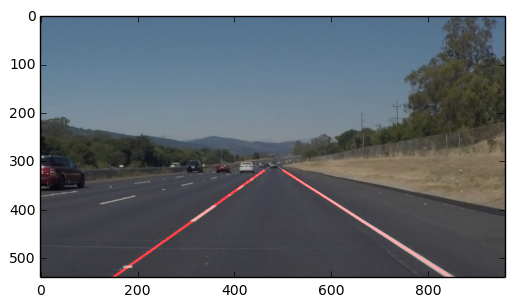

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import glob
for files in glob.glob("test_images/*_output.jpg"):
    os.remove(files)

for names in os.listdir("test_images/"):
    img = mpimg.imread(os.path.join('test_images', names))

    gimg = grayscale(img)

    gimg = gaussian_blur(gimg, 5)

    gimg = canny(gimg, 150, 200)

    gimg = region_of_interest(gimg, [np.array([[0, 539], [900, 539], [475, 305]])])

    limg = hough_lines_new(gimg, 1, np.pi/180, 30, 20, 20)

    plt.imshow(limg, cmap='gray')
    # np.tile(gimg[:, :, np.newaxis], [1, 1, 3])
    wimg = weighted_img(limg, img, 0.7)

    plt.imshow(wimg)
    filename, ext = os.path.splitext(names)
    plt.imsave(os.path.join('test_images', filename+'_output'+ext), wimg)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    gimg = grayscale(image)

    gimg = gaussian_blur(gimg, 5)

    gimg = canny(gimg, 150, 200)

    gimg = region_of_interest(gimg, [np.array([[0, 539], [900, 539], [475, 305]])])

    limg = hough_lines_new(gimg, 1, np.pi/180, 30, 20, 20)
    
    result = weighted_img(limg, image, 0.7)

    return result

Let's try the one with the solid white lane on the right first ...

In [66]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [01:28<00:00,  2.63it/s]     | 1/222 [00:00<01:39,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 28s, sys: 264 ms, total: 1min 28s
Wall time: 1min 28s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [04:40<00:00,  2.48it/s]     | 1/682 [00:00<05:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4min 41s, sys: 880 ms, total: 4min 41s
Wall time: 4min 41s


In [191]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


# Conclusion

After several rounds of trials, I feel that I'm almost there. The experiments on the testing images and two videos are satisfactory. The pipeline consists of several steps, and the main points are to extract the edges of the lanes and connect them using Hough transform. In the following, more details will be given, especially the method to connect line segments.

1. RGB to gray image conversion. When a colorful image is given, the first thing to do is to convert the 3-channel image to 1-channel gray image, which can be readily realized using OpenCV function. But I also find that in some situation, the gray image is not that of high contrast between the lanes and the ground, e.g., the images in the challenge video. Based on my observation, the R-channel may be a better choice. But that may be not good enough, and some more experiments have to be considered.

2. The Gaussian filter is implemented to remove some tiny details on the ground.

3. The ROI is mannully selected, and the Canny's method is implemented there.

4. Hough transform is applied to extract the lines.

5. Line segment connection strategy. In my first trial, I just make a polynomial fitting using the coordinates of Hough line segments. But after some experiments, I find that it is not enough. The main reason is that in the far end, more short line segments exist, and cause the least square fitting biased. Therefore, another strategy is considered, that is, to collect all the Canny edges which are close to these Hough lines, and using those selected edges to do the line fitting. I consider that as a kind of Hough filtering. The advantage is that the longer the Hough line segment is, the more edges it will cover. And that will give the longer lines bigger weights when doing line fitting. Based on my experiments, the results are way more robust than the naive one.

To make the pipeline more robust, some further improvements require to be considered.

1. As mentioned before, the RGB to Gray method should be carefully chosen. For the challenge video, the R-channel may be a better choice.

2. The Hough line connection strategy is better, but meanwhile the computational complexity also booms a lot, since the candidate edges require careful selection. The future improvement may be to make edge masks based on the Hough line segments, or using parallel computation.

3. The testing case is of quite ideal, that is, the lanes have high contrast to the ground. But that is not the case in many real life situations. Maybe the ground color is not that consistent (such as there are cracks, or is covered with some gravel), or even the lane cannot be observed (such as lanes are worn or covered by snow or rain). In those situations, the proposed pipeline will fail. Therefore some more practical strategy has to be designed.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [49]:
def process_image_720(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    gimg = gaussian_blur(image[:,:,0], 5)

    gimg = canny(gimg, 150, 200)

    gimg = region_of_interest(gimg, [np.array([[66, 711], [1176, 714], [699, 378]])])

    th, rmask = cv2.threshold(image[:,:,0], 150, 255, cv2.THRESH_BINARY)

    gimg = cv2.bitwise_and(gimg, rmask)
    try:
        limg = hough_lines_new_720(gimg, 1, np.pi/180, 30, 20, 20)
    except:
        limg = np.tile(gimg[:,:,np.newaxis], [1,1,3])

    result = weighted_img(limg, image, 0.7)

    return result

In [50]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_720)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 1/251 [00:00<01:49,  2.28it/s]

  1%|          | 2/251 [00:00<01:50,  2.26it/s]

  1%|          | 3/251 [00:01<01:48,  2.29it/s]

  2%|▏         | 4/251 [00:01<01:46,  2.33it/s]

  2%|▏         | 5/251 [00:02<01:45,  2.33it/s]

  2%|▏         | 6/251 [00:02<01:46,  2.30it/s]

  3%|▎         | 7/251 [00:03<01:45,  2.32it/s]

  3%|▎         | 8/251 [00:03<01:46,  2.29it/s]

  4%|▎         | 9/251 [00:03<01:48,  2.24it/s]

  4%|▍         | 10/251 [00:04<01:47,  2.24it/s]

  4%|▍         | 11/251 [00:04<01:48,  2.22it/s]

  5%|▍         | 12/251 [00:05<01:48,  2.20it/s]

  5%|▌         | 13/251 [00:05<01:47,  2.22it/s]

  6%|▌         | 14/251 [00:06<01:52,  2.11it/s]

  6%|▌         | 15/251 [00:06<01:47,  2.20it/s]

  6%|▋         | 16/251 [00:07<01:44,  2.26it/s]

  7%|▋         | 17/251 [00:07<01:44,  2.24it/s]

  7%|▋         | 18/251 [00:07<01:42,  2.28it/s]

  8%|▊         | 19/251 [00:08<01:39,  2.33it/s]

  8%|▊         |

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 40s, sys: 800 ms, total: 1min 41s
Wall time: 1min 41s


In [172]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))